# Nanopore long-read sequencing uncovers hundreds of structural variants in the Schistosome genome
*Shalini Nair, Elisha Enabulele, Xue Li, Tim Anderson, Neal Platt*

__ABSTRACT__: Nanopore sequencing generates extremely long sequence reads allowing detailed characterization of genomic features (genome rearrangements/structural variants) that are difficult to accurately assay using Illumina short-read sequencing approaches. Technological improvements in Nanopore long-read sequence have resulted in reduced prices, as well as increased accuracy and output. This method was declared “Method of the year” in Nature in 2022. Our laboratory is exploring the use of nanopore for characterizing pathogen genomes. Here, we detail application of nanopore sequencing of schistosome parasites. These parasites have a 380 Mb genome that is riddled with repetitive elements and structural variants. We have developed protocols that allow generation of reads up to 200kb, with 50% of reads > 24kb, and generation of 13.5 Gb of high-quality data from a single R10 flow cell, providing 27x coverage of the parasite genome.  Using this new data, we have identified multiple structural variants segregating in a lab strain of S. mansoni that would not have been visible using short read sequencing alone.  For example, we have found 468 large structural variants (>500bp) that were completely fixed in our laboratory population compared to the reference genome/strain. We anticipate that characterization of large structural variants may help to identify causative features underlying important schistosome phenotypes. Nanopore also has many possible uses for other researchers at Texas biomed, including sequencing entire viral genomes or host MHC, and rapid monitoring of infectious diseases in global populations.

**[08/04/2023] Nanopore analysis ideas**

- Are the genomes of lab populations syntenic or have large changes in gene structure/order been introduced?
  - __This would be extremely interesting__
  - Aside – one possible explanation for the division between Sh populations might be rearrangements/inversions
- What impact do large SVs have on the coding regions of the genome?
  - Comment – define impact here. It would certainly be interesting to know whether SVs in coding sequences seem likely to reduce/eliminate gene expression
- Is there evidence of population specific SVs (including CNVs/gene family expansions/contractions)?
- Can we recover and examine variability in complex regions like SmPoMucs and how is this variability distributed among and within lab populations?
  - __Yes – v important.__
  - Simply identifying the genome location of these genes will be very important – we would like to be able to definitively state that smPoMucs do/do not colocalize with the host specificity QTLs that Fred has mapped.
- Are there large SVs in important regions associated with parasite phenotypes?
  - Important question but difficult to do. I think we can certainly examine how many SVs are segregating in QTL regions, to highlight possible causative SVs
- (Some interesting question about the tandem repeat region in the mitochondrial genome...not sure what yet)
  - There is some old literature about these regions, suggesting v rapid change and extensive polymorphism within individuals. This might be difficult with the population data, but would be great to do when we have data from individual genotypes. Perhaps worth waiting until we have that data.
- __Is it possible to identify SVs that are being selected (for/against)?__
  - I think this is particularly interesting. We expect most SVs to be selected against.
  - Comparing allele frequencies within populations would be informative – we expect most to be at low frequency. High frequency SVs are good candidates for positive selection
  - __Comparing SV burden in coding vs non-coding regions would be informative to understand strength of selection against SVs__
  - __Likewise, comparing SVs in low and high recombination rate regions. We predict higher frequency/larger SVs in high recombination regions__

## Prep analyses

In [8]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import pysam
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import vcf

ModuleNotFoundError: No module named 'vcf'

In [2]:
proj_dir = "/master/nplatt/sch_man_ont"
ref_fas = "{}/data/genome/GCA_000237925.5.fa".format(proj_dir)
Path("{}/results".format(proj_dir)).mkdir(parents=True, exist_ok=True)

In [3]:
samples = [ "smor", 
            "smle_pzq_es",
            "smle_pzq_er",
            "smbre", 
            "smeg"        ]

pops=samples

In [4]:
os.chdir("{}/results".format(proj_dir))

## Filter reads

In [ ]:
#all raw reads are provided in results/raw_data

In [6]:
Path("{}/results/nanofilt".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/nanofilt".format(proj_dir))

In [43]:
for sample in samples:
    raw_fq = "{}/results/raw_reads/{}.raw_pass.fastq".format(proj_dir, sample)

    !~/anaconda3/envs/sm_ont-process_reads/bin/NanoFilt --length 500 --quality 7 --headcrop 25 --tailcrop 25 {raw_fq} >{sample}.filtered.fastq

In [ ]:
!conda run -n n50 --cwd . --live-stream n50 --format csv $(ls *.filtered.fastq) >n50_filtered_reads.csv

In [46]:
n50_df = pd.read_csv("n50_filtered_reads.csv", sep=",")
n50_df

,#path,seqs,size,N50,min,max,N75,N90,auN
0,smbre.filtered.fastq,2156891,13733527914,16145,500,193069,7657,2728,357349.74
1,smeg.filtered.fastq,2096508,12631573135,12491,500,236942,5659,2587,399825.88
2,smle_pzq_er.filtered.fastq,1330051,7000372416,12071,500,447354,4953,2105,227185.13
3,smor.filtered.fastq,3413369,14119478724,8668,500,168273,3430,1618,598308.11
4,smle_pzq_es.filtered.fastq,3662716,23840253863,13824,500,202196,5893,2659,624239.05


## Map reads

In [7]:
Path("{}/results/minimap2".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/minimap2".format(proj_dir))

In [49]:
# for sample in samples:
for sample in ["smle_pzq_es"]:
    sam      = "{}/results/minimap2/{}.sam".format(proj_dir, sample)
    query_fq = "{}/results/nanofilt/{}.filtered.fastq".format(proj_dir, sample)

    print("###################### {} ##################".format(sample))
    !~/anaconda3/envs/sm_ont-process_reads/bin/minimap2 -a -o {sam} -t 48 -x map-ont {ref_fas} {query_fq}

###################### smle_pzq_es ##################
[M::mm_idx_gen::11.489*1.68] collected minimizers
[M::mm_idx_gen::13.279*2.42] sorted minimizers
[M::main::13.279*2.42] loaded/built the index for 12 target sequence(s)
[M::mm_mapopt_update::14.118*2.34] mid_occ = 416
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 12
[M::mm_idx_stat::14.681*2.28] distinct minimizers: 30119087 (65.35% are singletons); average occurrences: 2.439; average spacing: 5.327; total length: 391422238
[M::worker_pipeline::214.298*29.98] mapped 42338 sequences
[M::worker_pipeline::390.138*31.90] mapped 40808 sequences
[M::worker_pipeline::588.947*32.25] mapped 43306 sequences
[M::worker_pipeline::830.022*32.30] mapped 45455 sequences
[M::worker_pipeline::1051.682*32.12] mapped 44703 sequences
[M::worker_pipeline::1289.362*31.59] mapped 45693 sequences
[M::worker_pipeline::1470.012*32.22] mapped 47806 sequences
[M::worker_pipeline::1696.452*32.12] mapped 45932 sequences
[M::worker_pipeline::1916.264

In [50]:
# for sample in samples:
for sample in ["smle_pzq_es"]:
    sam      = "{}/results/minimap2/{}.sam".format(proj_dir, sample)
    query_fq = "{}/results/nanofilt/{}.filtered.fastq".format(proj_dir, sample)
    
    print("###################### {} ##################".format(sample))

    #sort bam
    print("...sort...")
    ! ~/anaconda3/envs/sm_ont-process_reads/bin/samtools sort -O bam -o {sample}.bam {sample}.sam
    
    #index bam
    print("...index...")
    ! ~/anaconda3/envs/sm_ont-process_reads/bin/samtools index {sample}.bam
    
    #calculate coverage
    print("...coverage...")
    ! ~/anaconda3/envs/sm_ont-process_reads/bin/mosdepth --threads 4 {sample} {sample}.bam


###################### smle_pzq_es ##################
...sort...
[bam_sort_core] merging from 60 files and 1 in-memory blocks...
...index...
...coverage...


In [8]:
#calculate coverage for a table
!echo "sample,length,bases,mean,min,max">covs.csv
!grep "total" *mosdepth.summary.txt | sed 's/:/\t/' | sed 's/\t/,/g' | cut -f1,3-7 -d"," | sed 's/.mosdepth.summary.txt//' >>covs.csv

cov_df=pd.read_csv("covs.csv", sep=",")
cov_df

,sample,length,bases,mean,min,max
0,smbre,391422238,12929849971,33.03,0,50586
1,smeg,391422238,8667326476,22.14,0,34407
2,smle_pzq_er,391422238,6624879196,16.93,0,10350
3,smle_pzq_es,391422238,21017040798,53.69,0,43602
4,smor,391422238,12178154968,31.11,0,80622


In [ ]:
#play around with igv

## Identify structural variants

In [ ]:
Path("{}/results/cutesv".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/cutesv".format(proj_dir))

In [5]:
#sv call
# for sample in samples:
for sample in ["smle_pzq_es"]:

    print("###################### {} ##################".format(sample))

    bam      = "{}/results/minimap2/{}.bam".format(proj_dir, sample)
    query_fq = "{}/results/nanofilt/{}.filtered.fastq.gz".format(proj_dir, sample)
    out_dir  = "{}/{}".format(os.getcwd(), sample)
    
    Path("{}".format(out_dir)).mkdir(parents=True, exist_ok=True)
    !~/anaconda3/envs/cutesv/bin/cuteSV --max_cluster_bias_INS 100 --diff_ratio_merging_INS 0.3 --report_readid --max_cluster_bias_DEL 100 --diff_ratio_merging_DEL 0.3 --threads 12 --min_support 10 --genotype {bam} {ref_fas} {sample}.cutesv.vcf {out_dir}


###################### smle_pzq_es ##################
2023-01-18 11:31:03,178 [INFO] Running /master/nplatt/anaconda3/envs/cutesv/bin/cuteSV --max_cluster_bias_INS 100 --diff_ratio_merging_INS 0.3 --max_cluster_bias_DEL 100 --diff_ratio_merging_DEL 0.3 --threads 12 --min_support 10 --genotype /master/nplatt/sm_nanopore/results/minimap2/smle_pzq_es.bam /master/nplatt/sm_nanopore/data/genome/GCA_000237925.5.fa smle_pzq_es.cutesv.vcf /master/nplatt/sm_nanopore/results/smle_pzq_es
2023-01-18 11:31:10,070 [INFO] The total number of chromsomes: 12
2023-01-18 11:31:38,245 [INFO] Finished OU426849.1:10000000-10680109.
2023-01-18 11:33:46,325 [INFO] Finished HE601624.3:80000000-87984036.
2023-01-18 11:34:13,522 [INFO] Finished HE601624.3:30000000-40000000.
2023-01-18 11:34:14,461 [INFO] Finished HE601624.3:60000000-70000000.
2023-01-18 11:34:14,861 [INFO] Finished HE601624.3:50000000-60000000.
2023-01-18 11:34:15,292 [INFO] Finished HE601624.3:40000000-50000000.
2023-01-18 11:34:15,396 [INFO] F

In [8]:
#sv call
for sample in samples:
#for sample in ["smle_pzq_es"]:

    print("###################### {} ##################".format(sample))

    bam      = "{}/results/minimap2/{}.bam".format(proj_dir, sample)
    query_fq = "{}/results/nanofilt/{}.filtered.fastq.gz".format(proj_dir, sample)
    out_dir  = "{}/{}".format(os.getcwd(), sample)
    
    Path("{}".format(out_dir)).mkdir(parents=True, exist_ok=True)
    !~/anaconda3/envs/cutesv/bin/cuteSV --max_cluster_bias_INS 100 --diff_ratio_merging_INS 0.3 --report_readid --max_cluster_bias_DEL 100 --diff_ratio_merging_DEL 0.3 --threads 12 --min_support 10 {bam} {ref_fas} {sample}.cutesv.vcf {out_dir}


###################### smor ##################
2023-08-02 16:33:33,389 [INFO] Running /master/nplatt/anaconda3/envs/cutesv/bin/cuteSV --max_cluster_bias_INS 100 --diff_ratio_merging_INS 0.3 --report_readid --max_cluster_bias_DEL 100 --diff_ratio_merging_DEL 0.3 --threads 12 --min_support 10 /master/nplatt/sch_man_ont/results/minimap2/smor.bam /master/nplatt/sch_man_ont/data/genome/GCA_000237925.5.fa smor.cutesv.vcf /master/nplatt/sch_man_ont/results/cutesv/smor
2023-08-02 16:33:33,588 [INFO] The total number of chromsomes: 12
2023-08-02 16:33:35,747 [INFO] Finished OU426849.1:10000000-10680109.
2023-08-02 16:33:46,133 [INFO] Finished HE601624.3:80000000-87984036.
2023-08-02 16:33:47,986 [INFO] Finished HE601624.3:50000000-60000000.
2023-08-02 16:33:48,219 [INFO] Finished HE601624.3:30000000-40000000.
2023-08-02 16:33:48,219 [INFO] Finished OU426849.1:0-10000000.
2023-08-02 16:33:48,372 [INFO] Finished HE601624.3:60000000-70000000.
2023-08-02 16:33:48,374 [INFO] Finished HE601624.3:1000

## Identify SmPoMucs

From this [figure/paper](https://www.sciencedirect.com/science/article/pii/S0166685107003349#fig1) it seems we can use the 5' end to possibly identify single reads with SmPoMucs.

```GRMNKKIILLTIIYVALMIR```


```GGAAGAATGAACAAGAAAATTATTCTCTTAACAATTATATATGTTGCGCTGATGATAAGAGGTGAC```

Then there are 3 possible VNTRs that can be present up to 55x
 - r1: `DDYALSEPT`
 - r1': `DYYALSEPT`
 - r2: `GDLASDKPT`

Then there is a C-terminal region of 234 AAs


In [6]:
Path("{}/results/smpomuc".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/smpomuc".format(proj_dir))

In [ ]:
#run a blast with the aa seq and see what happens

In [140]:
%%bash

echo -e ">smpomuc_5p_aa\nGRMNKKIILLTIIYVALMIR" >smpomuc_5p_aa.fas
echo -e ">smpomuc_c-term\nVPEHLKTRIKHYKDAYFHSSIQKFLSLEPYTRASSTRAPQIYHEECLRLEKLYFTKWAVHYLSKNGATDITLLQSYENEYEEAKKGDKNADPRRDWGGQLRASISKKWKEREILDDVESAYIAGPRTNVNVNKEELKKQLTNTGNNIEAQLNNVKELESKAIQAANKHMNNRDDKSLEKQHKEAYSTLGKELRSLVDLMGEAEFQRILLLTTLPKDEQIKMIIQAMDKDSTNCS" >smpomuc_3p_aa.fas


echo -e ">smpomuc_5p_nuc\nGGAAGAATGAACAAGAAAATTATTCTCTTAACAATTATATATGTTGCGCTGATGATAAGAGGTGAC" >smpomuc_5p_nuc.fas
echo -e ">smpomuc_3p_exon_nuc\nGAGAATGATAATGTTTTCAACTAAACCTCAGTGTTTGTTTATGATATGGACAGACATGTTTTGGATCGTTAACAGTTTTCTGTGTCA" >smpomuc_3p_exon_nuc.fas

cat smpomuc_5p_nuc.fas smpomuc_3p_exon_nuc.fas >nuc.fas

In [129]:
%%bash 

for POP in "smle_pzq_er" "smle_pzq_es" "smbre" "smor" "smeg"; do
    zcat /master/nplatt/sch_man_ont/results/read_correction/${POP}/${POP}.correctedReads.fasta.gz >${POP}.correctedReads.fasta

    # conda run -n sm_ont-process_reads --cwd . --live-stream \
        # makeblastdb \
        #     -dbtype nucl \
        #     -in ${POP}.correctedReads.fasta

    conda run -n sm_ont-process_reads --cwd . --live-stream \
        blastn \
            -subject ${POP}.correctedReads.fasta \
            -query nuc.fas \
            -out nuc_vs_${POP}.blastn.tsv \
            -outfmt 6
    
done

Error while terminating subprocess (pid=33553): 


In [43]:
for pop in ["smle_pzq_er", "smle_pzq_es", "smbre", "smor", "smeg"]:
    #read in data
    df = pd.read_csv(f"smpomuc_5p_nuc_vs_{pop}.blastn.tsv", sep="\t", header=0)

    #change column names to make them useful
    col_names = ["q_seqid", "s_seqid", "p_ident", "length", "mismatch", "gapopen", "q_start", "q_end", "s_start", "s_end", "evalue", "bitscore"]
    df.columns=col_names

    #find possibly good hits
    df = df.loc[( (df["p_ident"] > 0.9) & (df["length"] > 60) )]

    #get orientation
    df["orient"] = "Na"

    df.loc[df["s_start"] < df["s_end"], "orient"] = "+"
    df.loc[df["s_start"] > df["s_end"], "orient"] = "-"

    #prep extraction by cleaning up orientation
    df["extract_start"] = df["s_start"]
    df["extract_end"] = df["s_end"]

    mask = df['orient'] == '-'
    df.loc[mask, ['extract_start', 'extract_end']] = df.loc[mask, ['extract_end', 'extract_start']].values

    #then adding a buffer to the 3' end of 3000 bp
    #df["extract_end"] = df["extract_end"] + 3_000

    # Open the SAM/BAM file
    df[['chr', 'chr_start', 'chr_stop']] = 'na'

    with pysam.AlignmentFile(f'{proj_dir}/results/minimap2/{pop}.bam', 'rb') as bamfile:

        s_seqids = set(df["s_seqid"])

        # Iterate over each read in the file
        for read in bamfile:

            # Check if the read is mapped
            if read.query_name in s_seqids:

                # Get the reference name, start, and end position
                ref_name = read.reference_name
                start = read.reference_start
                end = read.reference_end

                df.loc[df["s_seqid"] == read.query_name, "chr"]       = ref_name
                df.loc[df["s_seqid"] == read.query_name, "chr_start"] = start
                df.loc[df["s_seqid"] == read.query_name, "chr_stop"]  = end

    df = df.sort_values(by=["chr", "chr_start"])
    df.to_csv(f"{pop}_ind_reads_with_smpomuc_signal.csv", sep=",", header=True, index=False)

In [44]:
df

,q_seqid,s_seqid,p_ident,length,mismatch,gapopen,q_start,q_end,s_start,s_end,evalue,bitscore,orient,extract_start,extract_end,chr,chr_start,chr_stop
15,smpomuc_5p_nuc,b79e0aeb-0a87-41fc-94b9-919b498379da,95.38,65,3,0,1,65,18861,18925,3.000000e-27,104.0,+,18861,18925,HE601625.3,38357980,38397881
4,smpomuc_5p_nuc,df430d48-9250-4119-851f-6ba3fb44e4d3,95.38,65,3,0,1,65,6852,6788,3.000000e-27,104.0,-,6788,6852,HE601625.3,38360750,38384301
43,smpomuc_5p_nuc,b90cf0ab-b793-48b6-af81-bf857c2ea368,95.38,65,3,0,1,65,46714,46650,3.000000e-27,104.0,-,46650,46714,HE601625.3,38361373,38425380
35,smpomuc_5p_nuc,80fcd690-442d-42ba-96ba-ca5a998061a8,95.38,65,3,0,1,65,14768,14832,3.000000e-27,104.0,+,14768,14832,HE601625.3,38362406,38386007
3,smpomuc_5p_nuc,9011db49-5b2c-4b19-af76-8925088fdc2e,95.38,65,3,0,1,65,13647,13711,3.000000e-27,104.0,+,13647,13711,HE601625.3,38363532,38384631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,smpomuc_5p_nuc,265756c1-f961-4fc6-aa57-92d097dff38e,98.46,65,1,0,1,65,15436,15372,1.000000e-30,115.0,-,15372,15436,HE601627.3,30440967,30443696
39,smpomuc_5p_nuc,da1aaceb-88de-4308-9904-2a621a2141b5,98.46,65,1,0,1,65,5737,5801,1.000000e-30,115.0,+,5737,5801,HE601627.3,30446208,30446521
40,smpomuc_5p_nuc,da1aaceb-88de-4308-9904-2a621a2141b5,95.38,65,0,1,1,65,10960,10899,3.000000e-26,100.0,-,10899,10960,HE601627.3,30446208,30446521
25,smpomuc_5p_nuc,1cc203d9-3d54-43b5-bd9e-81c7793394be,95.38,65,3,0,1,65,13570,13634,3.000000e-27,104.0,+,13570,13634,HE601627.3,35197991,35201780


In [45]:
for pop in ["smle_pzq_er", "smle_pzq_es", "smbre", "smor", "smeg"]:

    df =  pd.read_csv(f"{pop}_ind_reads_with_smpomuc_signal.csv", sep=",")
    # Initialize a list to hold collapsed intervals
    collapsed = []

    # Set initial values to the first row
    last_chr = df.iloc[0]['chr']
    last_start = df.iloc[0]['chr_start']
    last_stop = df.iloc[0]['chr_stop']
    count = 1
    s_seqids = [df.iloc[0]['s_seqid']]  # Initialize with the first s_seqid

    for _, row in df.iterrows():
        # Check if the current interval overlaps with the last one
        if row['chr'] == last_chr and row['chr_start'] <= last_stop:
            # Update the end if needed
            last_stop = max(last_stop, row['chr_stop'])
            count += 1
            s_seqids.append(row['s_seqid'])
        else:
            # If no overlap, append the last interval, its count, and s_seqids to collapsed
            collapsed.append([last_chr, last_start, last_stop, count, s_seqids])
            last_chr, last_start, last_stop = row['chr'], row['chr_start'], row['chr_stop']
            count = 1
            s_seqids = [row['s_seqid']]  # Reset s_seqids list for the new interval

    # Append the last interval
    collapsed.append([last_chr, last_start, last_stop, count, s_seqids])

    # Convert collapsed to a DataFrame
    collapsed_df = pd.DataFrame(collapsed, columns=['chr', 'chr_start', 'chr_stop', 'element_count', 's_seqids'])
    collapsed_df.to_csv(f"{pop}_collapsed_smpomuc_intervals.csv", sep=",", header=True, index=False)

In [56]:
dfs={}
for pop in ["smle_pzq_er", "smle_pzq_es", "smbre", "smor", "smeg"]:
    df =  pd.read_csv(f"{pop}_collapsed_smpomuc_intervals.csv", sep=",")
    dfs[pop] = df.sort_values(by=['chr', 'chr_start'])

In [57]:
dfs["smle_pzq_er"]

,chr,chr_start,chr_stop,element_count,s_seqids
0,HE601625.3,38363642,38420684,12,"['c0ff4693-325f-43c9-ac1c-9832f1c76b08', 'c0ff..."
1,HE601627.3,30194954,30399004,45,"['7b16334e-76a8-452a-a519-fad791876f56', '66d3..."
2,HE601627.3,30413836,30461216,16,"['e6dd5aa6-c496-41cc-b0d1-8dba89b6846b', '6be9..."
3,HE601631.3,5441460,5441546,2,"['49132cb7-ae19-4ef6-b6a7-34f15a6229fb', 'bb59..."


In [58]:
dfs["smle_pzq_es"]

,chr,chr_start,chr_stop,element_count,s_seqids
0,HE601625.3,38283194,38445490,39,"['945315fe-8a3b-4002-bf71-be7fe9ee8add', '9453..."
1,HE601625.3,39684131,39707800,1,['61a28ffc-4302-4cb3-94a9-8a078f28ddc3']
2,HE601626.3,2249531,2249625,1,['fac960cf-0836-49e6-b3a6-0549b24c9a3b']
3,HE601627.3,30147379,30395686,94,"['d5b70a33-b833-450a-8c58-e9b2a11148d1', '1095..."
4,HE601627.3,30400670,30493911,28,"['84c2e89e-8bdd-4a73-8839-c2f20716d5ff', '10c6..."
5,HE601627.3,35200854,35201780,1,['86cbf181-83cc-46b8-aa03-c2ae3a8be6b3']
6,HE601631.3,3769918,3774437,1,['23c8af2f-c555-4c4e-9785-f791cdd53d2f']
7,HE601631.3,5441462,5441547,2,"['a99d9f7c-db65-4d8f-8b50-b2e3d1fccc5f', '4c58..."
8,OU426848.1,9813261,9815366,1,['2306227b-08a2-49ec-afae-ba9e6c97a40f']
9,OU426848.1,15768465,15769389,1,['456b4175-db0e-4eae-9e7e-b402f95f68ca']


In [59]:
dfs["smbre"]

,chr,chr_start,chr_stop,element_count,s_seqids
0,HE601625.3,38351497,38420684,20,"['5664ce76-28a2-43d5-86f5-2dd0146745be', '5664..."
1,HE601626.3,15820345,15821272,1,['971c58f1-77e6-48a6-b57c-d41f429e9fa7']
2,HE601627.3,30187303,30364768,56,"['08cba9c5-51bb-4484-8106-1d9028d4718b', '6736..."
3,HE601627.3,30372266,30397465,14,"['256c0c7f-03c4-4239-a114-bb0aa3e907e9', 'eb38..."
4,HE601627.3,30404618,30460203,15,"['0f94b17d-97ba-4064-a8ea-f6b42f7021b8', '4d05..."
5,HE601627.3,32215702,32216512,1,['03290737-30bd-415f-8475-9cae667f5f73']
6,HE601627.3,35198194,35199654,2,"['1dba2e6e-1a9e-42db-aeaf-f9b1f9d8c5cc', 'e582..."
7,HE601628.3,23177462,23177855,1,['086d5515-8bb3-407c-a142-b447c29f7aa8']
8,HE601631.3,5441462,5441547,1,['7c8f3faa-5ea0-4a94-85ad-8ec5a7384a55']


In [60]:
dfs["smor"]

,chr,chr_start,chr_stop,element_count,s_seqids
0,HE601625.3,38323935,38410524,24,"['902c4e70-d14d-418c-8412-e4dc9865462f', '902c..."
1,HE601626.3,2249529,2249653,1,['e07b74df-c837-45d1-8916-ef92a539cef5']
2,HE601627.3,30171304,30393183,66,"['9d89c37d-28ad-4bd9-a306-b65d6fdf07cd', '36a8..."
3,HE601627.3,30403402,30451912,10,"['0c96fcdb-ca56-4bb6-9226-9ad4c69ad9c8', 'e169..."
4,HE601630.3,7058606,7059275,1,['d8602e6f-b2fc-4180-b3b6-1b250aac8a84']
5,HE601631.3,5441461,5441535,1,['1498fed9-e443-4181-b2b2-12a6033c1ede']


In [61]:
dfs["smeg"]

,chr,chr_start,chr_stop,element_count,s_seqids
0,HE601625.3,38357980,38425380,14,"['b79e0aeb-0a87-41fc-94b9-919b498379da', 'b79e..."
1,HE601627.3,30184437,30229327,14,"['44d7e30f-b722-4218-814a-323e549a39dc', 'b00e..."
2,HE601627.3,30234783,30399004,31,"['07b185a4-5938-410f-a2e0-117560f66754', '58a9..."
3,HE601627.3,30399104,30447423,15,"['ebbd919c-5f80-41e7-8020-3fa71dc65e20', '8b2f..."
4,HE601627.3,35197991,35201780,1,['1cc203d9-3d54-43b5-bd9e-81c7793394be']
5,HE601631.3,5441464,5441546,1,['e34e77a8-6659-449e-ab63-5f11a0a59066']


In [141]:
%%bash 

ASSEM_DIR="/master/nplatt/sch_man_ont/results/assembly"

for POP in "smle_pzq_er" "smle_pzq_es" "smbre" "smor" "smeg"; do

    # conda run -n sm_ont-process_reads --cwd . --live-stream \
    #     makeblastdb \
    #         -dbtype nucl \
    #         -in ${ASSEM_DIR}/${POP}_rnd0.fasta

    conda run -n sm_ont-process_reads --cwd . --live-stream \
        blastn \
            -subject ${ASSEM_DIR}/${POP}_rnd0.fasta \
            -query nuc.fas \
            -out ${POP}_assem.blastn.tsv \
            -perc_identity 0.85 \
            -outfmt 6
    
done

In [340]:
%%bash 

conda run -n sm_ont-process_reads --cwd . --live-stream \
    blastn \
        -subject /master/nplatt/sch_man_ont/data/genome/SM_V9.fa \
        -query nuc.fas \
        -out smv9_assem.blastn.tsv \
        -perc_identity 0.85 \
        -outfmt 6

In [347]:
x

,0,1,2,3,4,5,6,7,8,9,10,11
0,smpomuc_5p_nuc,HE601625.3,95.38,65,3,0,1,65,38377257,38377321,1.000000e-22,104.0
1,smpomuc_5p_nuc,HE601627.3,98.46,65,1,0,1,65,30334716,30334652,6.000000e-26,115.0
2,smpomuc_5p_nuc,HE601627.3,98.44,64,1,0,2,65,30252316,30252253,2.000000e-25,113.0
3,smpomuc_5p_nuc,HE601627.3,96.92,65,2,0,1,65,30203241,30203177,3.000000e-24,110.0
4,smpomuc_5p_nuc,HE601627.3,96.92,65,2,0,1,65,30364285,30364221,3.000000e-24,110.0
5,smpomuc_5p_nuc,HE601627.3,93.85,65,4,0,1,65,30426262,30426198,6.000000e-21,99.0
6,smpomuc_3p_exon_nuc,HE601625.3,98.85,87,1,0,1,87,38364601,38364687,5.000000e-38,156.0
7,smpomuc_3p_exon_nuc,HE601625.3,98.85,87,1,0,1,87,38413014,38413100,5.000000e-38,156.0
8,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30170448,30170362,1.000000e-39,161.0
9,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30232621,30232535,1.000000e-39,161.0


In [350]:
x.loc[x[8] > x[9]]

,0,1,2,3,4,5,6,7,8,9,10,11
1,smpomuc_5p_nuc,HE601627.3,98.46,65,1,0,1,65,30334716,30334652,6.000000e-26,115.0
2,smpomuc_5p_nuc,HE601627.3,98.44,64,1,0,2,65,30252316,30252253,2.000000e-25,113.0
3,smpomuc_5p_nuc,HE601627.3,96.92,65,2,0,1,65,30203241,30203177,3.000000e-24,110.0
4,smpomuc_5p_nuc,HE601627.3,96.92,65,2,0,1,65,30364285,30364221,3.000000e-24,110.0
5,smpomuc_5p_nuc,HE601627.3,93.85,65,4,0,1,65,30426262,30426198,6.000000e-21,99.0
8,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30170448,30170362,1.000000e-39,161.0
9,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30232621,30232535,1.000000e-39,161.0
10,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30262656,30262570,1.000000e-39,161.0
11,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30434686,30434600,1.000000e-39,161.0
12,smpomuc_3p_exon_nuc,HE601627.3,95.40,87,4,0,1,87,30212841,30212755,5.000000e-33,139.0


In [353]:
xs

,0,1,2,3,4,5,6,7,8,9,10,11
1,smpomuc_5p_nuc,HE601627.3,98.46,65,1,0,1,65,30334716,30334652,6.000000e-26,115.0
2,smpomuc_5p_nuc,HE601627.3,98.44,64,1,0,2,65,30252316,30252253,2.000000e-25,113.0
3,smpomuc_5p_nuc,HE601627.3,96.92,65,2,0,1,65,30203241,30203177,3.000000e-24,110.0
4,smpomuc_5p_nuc,HE601627.3,96.92,65,2,0,1,65,30364285,30364221,3.000000e-24,110.0
5,smpomuc_5p_nuc,HE601627.3,93.85,65,4,0,1,65,30426262,30426198,6.000000e-21,99.0
8,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30170448,30170362,1.000000e-39,161.0
9,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30232621,30232535,1.000000e-39,161.0
10,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30262656,30262570,1.000000e-39,161.0
11,smpomuc_3p_exon_nuc,HE601627.3,100.00,87,0,0,1,87,30434686,30434600,1.000000e-39,161.0
12,smpomuc_3p_exon_nuc,HE601627.3,95.40,87,4,0,1,87,30212841,30212755,5.000000e-33,139.0


In [359]:
xs

1     30334716
2     30252316
3     30203241
4     30364285
5     30426262
8     30170448
9     30232621
10    30262656
11    30434686
12    30212841
13    30274916
14    30296637
15    30348669
16    30375260
17    30396858
Name: 8, dtype: int64

In [367]:
color_list[]

TypeError: list indices must be integers or slices, not list

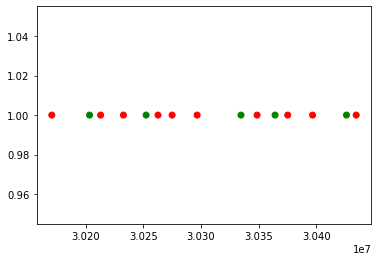

In [369]:
import matplotlib.pyplot as plt

colors={}
colors["smpomuc_5p_nuc"] = "green"
colors["smpomuc_3p_exon_nuc"] = "red"


x=pd.read_csv("smv9_assem.blastn.tsv", header=None, sep="\t")
x=x.loc[x[1] == "HE601627.3"]

color_list = [colors.get(item, "unknown") for item in x[0]]

xs=x[8]

plt.scatter(x=xs, y=[1]*len(xs), c=color_list)
plt.show()

In [ ]:
colors=[]

colors["smpomuc_5p_nuc"] = "green"
colors["smpomuc_3p_exon_nuc"] = "red"

for index, row in d

In [213]:
def blast_to_bed(blast_file):
    """
    Convert BLAST tabular output to BED format DataFrame including strand information.
    
    Parameters:
    - blast_file (str): Path to the BLAST tabular output file
    
    Returns:
    - DataFrame: BED formatted DataFrame
    """
    bed_records = []
    
    with open(blast_file, 'r') as blastf:
        for line in blastf:
            parts = line.strip().split('\t')
            
            # Assuming BLAST output columns are:
            # qseqid, sseqid, pident, length, mismatch, gapopen, qstart, qend, sstart, send, evalue, bitscore
            chrom = parts[1]
            sstart = int(parts[8])
            send = int(parts[9])
            
            # Determine orientation/strand
            if sstart < send:
                start, end, strand = sstart - 1, send, '+'
            else:
                start, end, strand = send - 1, sstart, '-'
            
            name = parts[0]
            
            score = "."
            bed_records.append([chrom, start, end, name, score, strand])

    df = pd.DataFrame(bed_records, columns=['chrom', 'start', 'end', 'name', 'score', 'strand'])
    
    return df



In [235]:
pops

['smor', 'smle_pzq_es', 'smle_pzq_er', 'smbre', 'smeg']

In [236]:
!cat smor_assem.blastn.tsv

smpomuc_5p_nuc	contig_512	93.85	65	4	0	1	65	24564	24500	7e-25	99.0
smpomuc_5p_nuc	contig_563	95.38	65	3	0	1	65	4166529	4166593	2e-26	104
smpomuc_5p_nuc	contig_586	98.46	65	1	0	1	65	26172	26236	7e-30	115
smpomuc_5p_nuc	contig_586	98.44	64	1	0	2	65	56069	56132	3e-29	113
smpomuc_5p_nuc	contig_586	95.38	65	3	0	1	65	107224	107288	2e-26	104
smpomuc_3p_exon_nuc	contig_2732	95.40	87	4	0	1	87	5809	5895	6e-37	139
smpomuc_3p_exon_nuc	contig_512	100.00	87	0	0	1	87	32990	32904	1e-43	161
smpomuc_3p_exon_nuc	contig_563	98.85	87	1	0	1	87	4151156	4151242	6e-42	156
smpomuc_3p_exon_nuc	contig_563	98.85	87	1	0	1	87	4195123	4195209	6e-42	156
smpomuc_3p_exon_nuc	contig_586	100.00	87	0	0	1	87	45743	45829	1e-43	161
smpomuc_3p_exon_nuc	contig_586	100.00	87	0	0	1	87	77866	77952	1e-43	161
smpomuc_3p_exon_nuc	contig_586	95.40	87	4	0	1	87	9838	9924	6e-37	139
smpomuc_3p_exon_nuc	contig_586	95.40	87	4	0	1	87	97630	97716	6e-37	139
smpomuc_3p_exon_nuc	contig_589	100.00	87	0	0	1	87	2064	2150	1e-43	161


In [238]:
blast_to_bed(blast_if)

,chrom,start,end,name,score,strand
0,contig_512,24499,24564,smpomuc_5p_nuc,.,-
1,contig_563,4166528,4166593,smpomuc_5p_nuc,.,+
2,contig_586,26171,26236,smpomuc_5p_nuc,.,+
3,contig_586,56068,56132,smpomuc_5p_nuc,.,+
4,contig_586,107223,107288,smpomuc_5p_nuc,.,+
5,contig_2732,5808,5895,smpomuc_3p_exon_nuc,.,+
6,contig_512,32903,32990,smpomuc_3p_exon_nuc,.,-
7,contig_563,4151155,4151242,smpomuc_3p_exon_nuc,.,+
8,contig_563,4195122,4195209,smpomuc_3p_exon_nuc,.,+
9,contig_586,45742,45829,smpomuc_3p_exon_nuc,.,+


In [237]:
for pop in ["smor"]:
    
    blast_if = f"{pop}_assem.blastn.tsv"
    bed_if   = f"{pop}_assem.blastn.bed"
    tsv_of  = f"{pop}_assem.blastn.paired.tsv"

    #convert blast to bed
    df = blast_to_bed(blast_if)
    df.to_csv(bed_of, sep="\t", header=False, index=False)
    
    print(df)
    # Split the DataFrame
    df_5p = df[df['name'] == 'smpomuc_5p_nuc'].copy()
    df_3p = df[df['name'] == 'smpomuc_3p_exon_nuc'].copy()

    # For storing pairs
    pairs = []

    # Loop through one DataFrame and find closest match in the other DataFrame
    for index, row_5p in df_5p.iterrows():
        closest_distance = float('inf')
        closest_row = None

        for _, row_3p in df_3p.iterrows():
            if row_5p['chrom'] == row_3p['chrom'] and row_5p['strand'] == row_3p['strand']:
                distance = row_5p['start'] - row_3p['start']
                if (row_5p['strand'] == "+" and distance < 0) or (row_5p['strand'] == "-" and distance > 0): 
                    if distance < closest_distance:
                        closest_distance = distance
                        closest_row = row_3p

        if closest_row is not None:
            pairs.append((row_5p, closest_row))
            # Remove the matched row from df_3p to prevent duplicate matches
            df_3p.drop(closest_row.name, inplace=True)


    combined_rows = []

    for pair in pairs:
        # Extend the two rows to form a single row for the pair
        combined_row = list(pair[0]) + list(pair[1])
        combined_rows.append(combined_row)

    # Create a DataFrame from combined rows
    columns =  list("5p_" + pair[0].index) + list("3p_" + pair[0].index) 
    df_pairs = pd.DataFrame(combined_rows, columns=columns)

    df_pairs.to_csv(tsv_of, sep="\t", header=True, index=False)
    print(df_pairs)

          chrom    start      end                 name score strand
0    contig_512    24499    24564       smpomuc_5p_nuc     .      -
1    contig_563  4166528  4166593       smpomuc_5p_nuc     .      +
2    contig_586    26171    26236       smpomuc_5p_nuc     .      +
3    contig_586    56068    56132       smpomuc_5p_nuc     .      +
4    contig_586   107223   107288       smpomuc_5p_nuc     .      +
5   contig_2732     5808     5895  smpomuc_3p_exon_nuc     .      +
6    contig_512    32903    32990  smpomuc_3p_exon_nuc     .      -
7    contig_563  4151155  4151242  smpomuc_3p_exon_nuc     .      +
8    contig_563  4195122  4195209  smpomuc_3p_exon_nuc     .      +
9    contig_586    45742    45829  smpomuc_3p_exon_nuc     .      +
10   contig_586    77865    77952  smpomuc_3p_exon_nuc     .      +
11   contig_586     9837     9924  smpomuc_3p_exon_nuc     .      +
12   contig_586    97629    97716  smpomuc_3p_exon_nuc     .      +
13   contig_589     2063     2150  smpomuc_3p_ex

,5p_chrom,5p_start,5p_end,5p_name,5p_score,5p_strand,3p_chrom,3p_start,3p_end,3p_name,3p_score,3p_strand
0,contig_1873,78173,78238,smpomuc_5p_nuc,.,-,contig_1873,56527,56614,smpomuc_3p_exon_nuc,.,-
1,contig_1873,46215,46279,smpomuc_5p_nuc,.,-,contig_1873,29572,29659,smpomuc_3p_exon_nuc,.,-
2,contig_324,725269,725334,smpomuc_5p_nuc,.,-,contig_324,690545,690632,smpomuc_3p_exon_nuc,.,-


In [225]:
for pop in pops:
    
    bed_of   = f"{pop}_assem.paired.bed"
    tsv_if  = f"{pop}_assem.blastn.paired.tsv"
    df_pairs = pd.read_csv(tsv_if, sep="\t")
    
    bed_rows=[]

    for index, row in df_pairs.iterrows():
        start = row[["5p_start", "5p_end", "3p_start", "3p_end"]].min()
        stop = row[["5p_start", "5p_end", "3p_start", "3p_end"]].max()
        chrom = row["5p_chrom"]
        orient= row["5p_strand"]

        name=f"{chrom}:{start}-{stop}({orient})"

        bed_rows.append([chrom, start, stop, name, ".", orient])
        columns=["chrom", "start", "stop", "name", ".", "orient"]

        df_bed=pd.DataFrame(bed_rows, columns=columns)
        df_bed.to_csv(bed_of, sep="\t", header=False, index=False)
    print(df_bed)
#df_bed

        chrom    start     stop                           name  . orient
0  contig_512    24499    32990      contig_512:24499-32990(-)  .      -
1  contig_563  4151155  4166593  contig_563:4151155-4166593(+)  .      +
2  contig_586     9837    26236       contig_586:9837-26236(+)  .      +
3  contig_586    45742    56132      contig_586:45742-56132(+)  .      +
4  contig_586    97629   107288     contig_586:97629-107288(+)  .      +
        chrom    start     stop                           name  . orient
0  contig_292  3053118  3068566  contig_292:3053118-3068566(+)  .      +
1   contig_86  2132083  2140572   contig_86:2132083-2140572(+)  .      +
2   contig_88    53616    67630       contig_88:53616-67630(+)  .      +
3   contig_88    87165    97561       contig_88:87165-97561(+)  .      +
4   contig_88   140016   149678     contig_88:140016-149678(+)  .      +
        chrom    start     stop                           name  . orient
0  contig_471  2097237  2105657  contig_471:2097237

In [195]:
# %%bash

# #slop
# L_BUFFER=3
# R_BUFFER=3

# ASSEM_DIR="/master/nplatt/sch_man_ont/results/assembly"

# for POP in smle_pzq_er smle_pzq_es smbre smor smeg; do
#     FAS="/master/nplatt/sch_man_ont/results/assembly/${POP}_rnd0.fasta"
#     I_BED=${POP}"_assem.blastn.bed"
#     O_BED=${POP}"_assem.blastn.slop.bed"
    
#     conda run -n sm_ont-process_reads samtools faidx ${FAS}
#     cut -f1,2 ${FAS}.fai > ${FAS}.size
    
#     conda run -n sm_ont-process_reads bedtools slop -s -l ${L_BUFFER} -r ${R_BUFFER} -g ${FAS}.size -i ${I_BED} >${O_BED}

# done

In [94]:
#exctract those regions

In [207]:
%%bash

ASSEM_DIR="/master/nplatt/sch_man_ont/results/assembly"

for POP in "smle_pzq_er" "smle_pzq_es" "smbre" "smor" "smeg"; do

    FI=${ASSEM_DIR}/${POP}_rnd0.fasta
    FO=${POP}_assem.paired.fasta
    BED=${POP}_assem.paired.bed
    
    conda run -n sm_ont-process_reads bedtools getfasta -s -fi ${FI} -bed ${BED} -fo ${FO}
done

In [208]:
for pop in pops:
    input_fasta = f"{pop}_assem.paired.fasta"
    output_fasta =f"{pop}_assem.paired.mod.fasta"

    sequences = SeqIO.parse(input_fasta, "fasta")

    # Modify the headers
    modified_sequences = []
    for seq in sequences:
        seq.id = f"{pop}_{seq.id}"
        seq.description = ''  # Resetting the description ensures that only the ID gets written out
        modified_sequences.append(seq)

    # Write the modified sequences to the output file
    SeqIO.write(modified_sequences, output_fasta, "fasta")


In [209]:
!cat *_assem.paired.mod.fasta >test.paired.fasta

In [ ]:
r1 GATGACTATGCATTGAGCGAACCAACA
r1p GATTACTATGCATTGAGCGAACCAACA
r2 GGTGACCTCGCATCAGACAAACCCACA

In [ ]:
%%bash

ASSEM_DIR="/master/nplatt/sch_man_ont/results/assembly"
cat smpomuc_5p_aa.fas smpomuc_3p_aa.fas >aa.fas


for POP in "smle_pzq_er" "smle_pzq_es" "smbre" "smor" "smeg"; do

    conda run -n sm_ont-process_reads --cwd . --live-stream \
        makeblastdb \
            -dbtype nucl \
            -in ${ASSEM_DIR}/${POP}_rnd0.fasta

    conda run -n sm_ont-process_reads --cwd . --live-stream \
        tblastn \
            -subject ${ASSEM_DIR}/${POP}_rnd0.fasta \
            -query aa.fas \
            -out ${POP}_assem.aa.tblastn.tsv \
            -outfmt 6
    
done

In [111]:
# for pop in ["smle_pzq_er", "smle_pzq_es", "smbre", "smor", "smeg"]:

pop="smbre"

#read in data
df = pd.read_csv(f"{pop}_assm.aa.tblastn.tsv", sep="\t", header=0)

#change column names to make them useful
col_names = ["q_seqid", "s_seqid", "p_ident", "length", "mismatch", "gapopen", "q_start", "q_end", "s_start", "s_end", "evalue", "bitscore"]
df.columns=col_names

# #find possibly good hits
# df.loc[( (df["p_ident"] > 0.9) & (df["length"] > 62) )]

In [120]:
df.loc[( (df["p_ident"] > 50) & (df["length"] > 24) )]

,q_seqid,s_seqid,p_ident,length,mismatch,gapopen,q_start,q_end,s_start,s_end,evalue,bitscore
373,smpomuc_c-term,contig_105,84.62,26,4,0,209,234,27564,27641,7.000000e-17,49.3
374,smpomuc_c-term,contig_105,58.97,39,14,1,180,216,27436,27552,7.000000e-17,40.4
376,smpomuc_c-term,contig_105,92.00,25,2,0,151,175,26625,26699,2.000000e-07,47.8
377,smpomuc_c-term,contig_105,73.08,26,7,0,46,71,22392,22469,3.000000e-07,47.0
378,smpomuc_c-term,contig_105,71.43,28,8,0,17,44,21887,21970,8.000000e-07,45.8
384,smpomuc_c-term,contig_105,53.33,30,14,0,107,136,24927,25016,1.200000e-02,33.1
412,smpomuc_c-term,contig_111,51.72,29,13,1,46,74,2150682,2150599,7.400000e+00,25.4
472,smpomuc_c-term,contig_1224,84.62,26,4,0,209,234,10624,10547,1.000000e-19,49.3
473,smpomuc_c-term,contig_1224,84.62,26,4,0,209,234,58331,58254,4.000000e-19,49.3
474,smpomuc_c-term,contig_1224,84.62,26,4,0,209,234,30384,30307,4.000000e-19,49.3


In [254]:
!echo -e "smpomuc\tGGAAGAATGAACAAGAAAATTATTCTCTTAACAATTATATATGTTGCGCTGATGATAAGAGGTGAC\tGAGAATGATAATGTTTTCAACTAAACCTCAGTGTTTGTTTATGATATGGACAGACATGTTTTGGATCGTTAACAGTTTTCTGTGTCA" >primers.txt
!echo -e "smpomuc\tATGAACAAGAAAATTATTCTC\tCGTTAACAGTTTTCTGTGTCA" >primers.txt
                                            #12345678901123456789012

In [ ]:
%%bash

conda run -n sm_ont-process_reads isPcr -out=bed -maxSize=1000000 -flipReverse ../../data/genome/SM_V9.fa primers.txt smv9.bed

In [283]:
for pop in pops + ["smv9"]:
    
    # fas = f"/master/nplatt/sch_man_ont/results/assembly/{pop}_rnd0.fasta"
    # cmd=f"isPcr -out=bed -maxSize=1000000 -flipReverse {fas} primers.txt {pop}.pcr.bed"
    # print(cmd)
    # !cmd

    df=pd.read_csv(f"{pop}.pcr.bed", sep="\t", header=None)
    df.columns=["chrom", "start", "stop", "name", "score", "strand"]
    df["len"] = df["stop"] - df["start"]

    df=df.sort_values(by=['start', 'len'], ascending=True).reset_index(drop=True)


    idx = df.groupby(['chrom', 'start'])['len'].idxmin()
    df = df.loc[idx].reset_index(drop=True)
    idx = df.groupby(['chrom', 'stop'])['len'].idxmin()
    df = df.loc[idx].reset_index(drop=True)
    df.to_csv(f"{pop}.pcr.collapsed.bed", sep="\t", header=False, index=False)

In [290]:
df

,chrom,start,stop,name,score,strand,len
0,HE601625.3,38377262,38413100,smpomuc,1000,+,35838
1,HE601627.3,30170361,30203235,smpomuc,1000,-,32874
2,HE601627.3,30232534,30252311,smpomuc,1000,-,19777
3,HE601627.3,30296550,30334710,smpomuc,1000,-,38160
4,HE601627.3,30348582,30364279,smpomuc,1000,-,15697
5,HE601627.3,30396771,30426256,smpomuc,1000,-,29485


In [279]:
%%bash

ASSEM_DIR="/master/nplatt/sch_man_ont/results/assembly"

for POP in "smle_pzq_er" "smle_pzq_es" "smbre" "smor" "smeg"; do

    FI=${ASSEM_DIR}/${POP}_rnd0.fasta
    FO=${POP}.pcr.collapsed.fasta
    BED=${POP}.pcr.collapsed.bed
    
    conda run -n sm_ont-process_reads bedtools getfasta -s -fi ${FI} -bed ${BED} -fo ${FO}
done

In [287]:
%%bash

conda run -n sm_ont-process_reads bedtools getfasta -s -fi ../../data/genome/SM_V9.fa -bed smv9.pcr.collapsed.bed -fo smv9.pcr.collapsed.fasta

In [288]:
for pop in pops + ["smv9"]:
    input_fasta = f"{pop}.pcr.collapsed.fasta"
    output_fasta =f"{pop}.pcr.collapsed.mod.fasta"

    sequences = SeqIO.parse(input_fasta, "fasta")

    # Modify the headers
    modified_sequences = []
    for seq in sequences:
        seq.id = f"{pop}_{seq.id}"
        seq.description = ''  # Resetting the description ensures that only the ID gets written out
        modified_sequences.append(seq)

    # Write the modified sequences to the output file
    SeqIO.write(modified_sequences, output_fasta, "fasta")


In [289]:
!cat *.pcr.collapsed.mod.fasta >ispcr.paired.fasta

In [ ]:
HE601627.3:30170361-30426256

In [260]:
idx = df.groupby(['chrom', 'start', 'stop'])['len'].idxmin()

# Use the indices to filter the dataframe
collapsed_df = df.loc[idx].reset_index(drop=True)

collapsed_df

,chrom,start,stop,name,score,strand,len
0,HE601625.3,38377262,38413100,smpomuc,1000,+,35838
1,HE601627.3,30170361,30203235,smpomuc,1000,-,32874
2,HE601627.3,30170361,30252311,smpomuc,1000,-,81950
3,HE601627.3,30170361,30334710,smpomuc,1000,-,164349
4,HE601627.3,30170361,30364279,smpomuc,1000,-,193918
5,HE601627.3,30170361,30426256,smpomuc,1000,-,255895
6,HE601627.3,30212754,30252311,smpomuc,1000,-,39557
7,HE601627.3,30212754,30334710,smpomuc,1000,-,121956
8,HE601627.3,30212754,30364279,smpomuc,1000,-,151525
9,HE601627.3,30212754,30426256,smpomuc,1000,-,213502


In [ ]:
import pysam

# Open the SAM/BAM file
with pysam.AlignmentFile('path_to_your_file.bam', 'rb') as bamfile:
    # Iterate over each read in the file
    for read in bamfile:
        # Check if the read is mapped
        if not read.is_unmapped:
            # Get the reference name, start, and end position
            ref_name = read.reference_name
            start = read.reference_start
            end = read.reference_end

            print(f"Read: {read.query_name}, Mapped to: {ref_name}, Start: {start}, End: {end}")

In [ ]:
%%bash

cat "">smv9_smpomuc_locus.fas


In [295]:
%%bash 

ASSEM_DIR="/master/nplatt/sch_man_ont/results/assembly"

for POP in "smle_pzq_er" "smle_pzq_es" "smbre" "smor" "smeg"; do

    conda run -n sm_ont-process_reads --cwd . --live-stream \
        blastn \
            -subject ${ASSEM_DIR}/${POP}_rnd0.fasta \
            -query chr4_smpomuc_smv9.fas \
            -out ${POP}_loc.blastn.tsv \
            -perc_identity 0.85 \
            -outfmt 6
    
done

In [308]:
for pop in ["smle_pzq_er"]:
    
    blast_if = f"{pop}_loc.blastn.tsv"
#     bed_if   = f"{pop}_assem.blastn.bed"
#     tsv_of  = f"{pop}_assem.blastn.paired.tsv"

#     #convert blast to bed
#     df = blast_to_bed(blast_if)
#     df.to_csv(bed_of, sep="\t", header=False, index=False)

df=pd.read_csv(blast_if, sep="\t", header=None)
df.columns=["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
df

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,HE601627.3:30170361-30426256,contig_1001,97.79,3985,82,3,207044,211025,4937,956,0.000000e+00,6866.0
1,HE601627.3:30170361-30426256,contig_1001,97.79,3985,82,3,106700,110681,4937,956,0.000000e+00,6866.0
2,HE601627.3:30170361-30426256,contig_1001,97.76,3747,78,3,180454,184197,4937,1194,0.000000e+00,6449.0
3,HE601627.3:30170361-30426256,contig_1001,96.03,2417,89,6,207044,209456,12703,10290,0.000000e+00,3925.0
4,HE601627.3:30170361-30426256,contig_1001,96.03,2417,89,6,180454,182866,12703,10290,0.000000e+00,3925.0
...,...,...,...,...,...,...,...,...,...,...,...,...
113591,HE601627.3:30170361-30426256,contig_998,90.91,110,10,0,135119,135228,111282,111391,2.000000e-35,148.0
113592,HE601627.3:30170361-30426256,contig_998,87.60,121,15,0,51476,51596,145041,144921,3.000000e-33,141.0
113593,HE601627.3:30170361-30426256,contig_998,91.01,89,8,0,131997,132085,141723,141635,5.000000e-27,121.0
113594,HE601627.3:30170361-30426256,contig_998,91.01,89,8,0,131997,132085,153893,153981,5.000000e-27,121.0


In [309]:
df["hit_len"] = abs(df["send"] - df["sstart"])
df.sort_values(by='hit_len', ascending=True).reset_index(drop=True)
df

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,hit_len
0,HE601627.3:30170361-30426256,contig_1001,97.79,3985,82,3,207044,211025,4937,956,0.000000e+00,6866.0,3981
1,HE601627.3:30170361-30426256,contig_1001,97.79,3985,82,3,106700,110681,4937,956,0.000000e+00,6866.0,3981
2,HE601627.3:30170361-30426256,contig_1001,97.76,3747,78,3,180454,184197,4937,1194,0.000000e+00,6449.0,3743
3,HE601627.3:30170361-30426256,contig_1001,96.03,2417,89,6,207044,209456,12703,10290,0.000000e+00,3925.0,2413
4,HE601627.3:30170361-30426256,contig_1001,96.03,2417,89,6,180454,182866,12703,10290,0.000000e+00,3925.0,2413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113591,HE601627.3:30170361-30426256,contig_998,90.91,110,10,0,135119,135228,111282,111391,2.000000e-35,148.0,109
113592,HE601627.3:30170361-30426256,contig_998,87.60,121,15,0,51476,51596,145041,144921,3.000000e-33,141.0,120
113593,HE601627.3:30170361-30426256,contig_998,91.01,89,8,0,131997,132085,141723,141635,5.000000e-27,121.0,88
113594,HE601627.3:30170361-30426256,contig_998,91.01,89,8,0,131997,132085,153893,153981,5.000000e-27,121.0,88


In [311]:
%%bash

~/anaconda3/envs/sm_ont-process_reads/bin/minimap2 -a -o test.sam -t 48 -x map-ont ../assembly/smle_pzq_er_rnd0.fasta chr4_smpomuc_smv9.fas

[M::mm_idx_gen::8.442*1.65] collected minimizers
[M::mm_idx_gen::9.858*2.78] sorted minimizers
[M::main::9.859*2.78] loaded/built the index for 1968 target sequence(s)
[M::mm_mapopt_update::10.615*2.65] mid_occ = 373
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1968
[M::mm_idx_stat::11.135*2.57] distinct minimizers: 30209362 (65.19% are singletons); average occurrences: 2.377; average spacing: 5.323; total length: 382213358
[M::worker_pipeline::32.461*1.54] mapped 1 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: /master/nplatt/anaconda3/envs/sm_ont-process_reads/bin/minimap2 -a -o test.sam -t 48 -x map-ont ../assembly/smle_pzq_er_rnd0.fasta chr4_smpomuc_smv9.fas
[M::main] Real time: 32.710 sec; CPU: 50.182 sec; Peak RSS: 3.120 GB


In [314]:
df=pd.read_csv("test.sam", sep="\t", header=None, comment='@')
df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,HE601627.3:30170361-30426256,0,contig_908,1385,60,68821S291M1I862M1D399M1D283M1I11M2D2M45D102M1D...,*,0,0,TTGACACAGAAAACTGTTAACGATCCAAAACATGTCTGTCCATATC...,...,AS:i:122090,nn:i:200,tp:A:P,cm:i:15615,s1:i:80466,s2:i:33012,de:f:0.0102,zd:i:1,"SA:Z:contig_1657,92,-,188036S34560M21I33279S,6...",rl:i:10614
1,HE601627.3:30170361-30426256,2064,contig_1657,92,60,188036H1831M1D2764M1D1988M1I590M1I350M8I766M6D...,*,0,0,TTATTTCTTCTCGTCTAGTCCTACACGTTTGAATCCAGAACACAAT...,...,AS:i:68198,nn:i:0,tp:A:P,cm:i:5222,s1:i:29788,s2:i:0,de:f:0.0042,"SA:Z:contig_908,1385,+,68821S100592M52553I3393...",rl:i:10614,NaN
2,HE601627.3:30170361-30426256,2048,contig_191,5569193,60,201909H512M1D160M2I593M16D289M3I4M7I2M4I135M1I...,*,0,0,TTCGGAAAATTCAGGGCCTAGTTTTATTTCGCTTATACAAAGGTGC...,...,AS:i:38364,nn:i:100,tp:A:P,cm:i:5577,s1:i:27979,s2:i:24967,de:f:0.0249,"SA:Z:contig_908,1385,+,68821S100592M52553I3393...",rl:i:10614,NaN
3,HE601627.3:30170361-30426256,256,contig_191,5589245,0,228744S88M1I115M1D27M2I10M1D19M14I8M2I439M1I2M...,*,0,0,*,...,AS:i:50787,nn:i:0,tp:A:S,cm:i:4567,s1:i:24967,de:f:0.0082,rl:i:10614,NaN,NaN,NaN
4,HE601627.3:30170361-30426256,272,contig_757,647,0,402S19M3I77M17D918M6I10M6I10M8I1064M2D6M4D9M5D...,*,0,0,*,...,AS:i:48992,nn:i:0,tp:A:S,cm:i:4150,s1:i:22491,de:f:0.0183,zd:i:1,rl:i:10614,NaN,NaN
5,HE601627.3:30170361-30426256,256,contig_191,5591314,0,228744S88M1I142M2I33M13I5M2I442M1D8M1D303M1D24...,*,0,0,*,...,AS:i:49127,nn:i:0,tp:A:S,cm:i:4443,s1:i:24102,de:f:0.0067,rl:i:10614,NaN,NaN,NaN
6,HE601627.3:30170361-30426256,2048,contig_908,1385,60,3433H291M1I862M1D399M1D271M1D28M7D6M1D2M4D3M10...,*,0,0,TAATGATTCTCATTATAAACCTATCAAATTACTAAACGAACAGTTT...,...,AS:i:3669,nn:i:0,tp:A:P,cm:i:2613,s1:i:13415,s2:i:29788,de:f:0.0313,zd:i:1,"SA:Z:contig_908,1385,+,68821S100592M52553I3393...",rl:i:10614
7,HE601627.3:30170361-30426256,2064,contig_1657,23032,49,253385H469M1I1055M1D986M,*,0,0,TATCAGAACGAACAGCCTAGAGTCAACTCTCAGTCCGTATTATTTC...,...,AS:i:4732,nn:i:0,tp:A:P,cm:i:385,s1:i:2182,s2:i:2549,de:f:0.0191,zd:i:2,"SA:Z:contig_908,1385,+,68821S100592M52553I3393...",rl:i:10614
8,HE601627.3:30170361-30426256,272,contig_908,102218,0,30277S7M1I378M1I448M16D591M4I681M223508S,*,0,0,*,...,AS:i:3964,nn:i:0,tp:A:i,cm:i:0,s1:i:0,de:f:0.0166,rl:i:10614,NaN,NaN,NaN
9,HE601627.3:30170361-30426256,2064,contig_471,2105599,60,336M255560H,*,0,0,ATGAACAAGAAAATTATTCTCTTGACAATAATATATATTGCGCTGA...,...,AS:i:666,nn:i:0,tp:A:P,cm:i:54,s1:i:320,s2:i:78,de:f:0.0030,"SA:Z:contig_908,1385,+,68821S100592M52553I3393...",rl:i:10614,NaN


In [ ]:
["QNAME",
"FLAG",
"RNAME",
"POS",
"MAPQ",
"CIGAR",
"RNEXT",
"PNEXT",
"TLEN",
"SEQ",
"QUA"]

In [ ]:
#split the smv9 smpomuc locus into 20kb chunks then map these to the genomes with minimap2

In [316]:
def sliding_window(sequence, window_size, step_size):
    """Generate chunks of sequence based on a sliding window."""
    for i in range(0, len(sequence) - window_size + 1, step_size):
        yield sequence[i:i+window_size]

In [325]:
# Read the sequence from a FASTA file
input_file = 'chr4_smpomuc_smv9.fas'
output_file = 'chr4_smpomuc_smv9_chunked.fas'

window=30_000
step=30_000

chunks = []

with open(input_file, 'r') as fasta_file:
    for record in SeqIO.parse(fasta_file, 'fasta'):
        seq_id = record.id
        seq = record.seq

        # Split the sequence using the sliding window and store the chunks
        for index, chunk in enumerate(sliding_window(seq, window, step), 1):
            new_record = SeqRecord(chunk, id=f"{seq_id}_chunk{index}", description="")
            chunks.append(new_record)

# Save the chunks to a new FASTA file
with open(output_file, 'w') as output:
    SeqIO.write(chunks, output, 'fasta')

In [337]:
%%bash
#chr4_smpomuc_smv9.fas
#chr4_smpomuc_smv9_chunked.fas
~/anaconda3/envs/sm_ont-process_reads/bin/minimap2 -a -o test.sam -t 48 -x map-ont ../assembly/smor_rnd0.fasta chr4_smpomuc_smv9.fas

[M::mm_idx_gen::7.514*1.70] collected minimizers
[M::mm_idx_gen::8.702*2.76] sorted minimizers
[M::main::8.702*2.76] loaded/built the index for 1674 target sequence(s)
[M::mm_mapopt_update::9.411*2.62] mid_occ = 384
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1674
[M::mm_idx_stat::9.927*2.54] distinct minimizers: 30374815 (65.19% are singletons); average occurrences: 2.391; average spacing: 5.323; total length: 386656054
[M::worker_pipeline::38.716*1.39] mapped 1 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: /master/nplatt/anaconda3/envs/sm_ont-process_reads/bin/minimap2 -a -o test.sam -t 48 -x map-ont ../assembly/smor_rnd0.fasta chr4_smpomuc_smv9.fas
[M::main] Real time: 39.012 sec; CPU: 54.223 sec; Peak RSS: 3.220 GB


In [329]:
!samtools view -F0x100 chunks.sam >filtered.sam

[bam_header_read] EOF marker is absent. The input is probably truncated.
[bam_header_read] invalid BAM binary header (this is not a BAM file).
[main_samview] fail to read the header from "chunks.sam".


In [334]:
df=pd.read_csv("test.sam", sep="\t", header=None, comment='@', usecols=range(11))
# df.loc[df[2] == "contig_908"]
df

,0,1,2,3,4,5,6,7,8,9,10
0,HE601627.3:30170361-30426256,0,contig_908,1385,60,68821S291M1I862M1D399M1D283M1I11M2D2M45D102M1D...,*,0,0,TTGACACAGAAAACTGTTAACGATCCAAAACATGTCTGTCCATATC...,*
1,HE601627.3:30170361-30426256,2064,contig_1657,92,60,188036H1831M1D2764M1D1988M1I590M1I350M8I766M6D...,*,0,0,TTATTTCTTCTCGTCTAGTCCTACACGTTTGAATCCAGAACACAAT...,*
2,HE601627.3:30170361-30426256,2048,contig_191,5569193,60,201909H512M1D160M2I593M16D289M3I4M7I2M4I135M1I...,*,0,0,TTCGGAAAATTCAGGGCCTAGTTTTATTTCGCTTATACAAAGGTGC...,*
3,HE601627.3:30170361-30426256,256,contig_191,5589245,0,228744S88M1I115M1D27M2I10M1D19M14I8M2I439M1I2M...,*,0,0,*,*
4,HE601627.3:30170361-30426256,272,contig_757,647,0,402S19M3I77M17D918M6I10M6I10M8I1064M2D6M4D9M5D...,*,0,0,*,*
5,HE601627.3:30170361-30426256,256,contig_191,5591314,0,228744S88M1I142M2I33M13I5M2I442M1D8M1D303M1D24...,*,0,0,*,*
6,HE601627.3:30170361-30426256,2048,contig_908,1385,60,3433H291M1I862M1D399M1D271M1D28M7D6M1D2M4D3M10...,*,0,0,TAATGATTCTCATTATAAACCTATCAAATTACTAAACGAACAGTTT...,*
7,HE601627.3:30170361-30426256,2064,contig_1657,23032,49,253385H469M1I1055M1D986M,*,0,0,TATCAGAACGAACAGCCTAGAGTCAACTCTCAGTCCGTATTATTTC...,*
8,HE601627.3:30170361-30426256,272,contig_908,102218,0,30277S7M1I378M1I448M16D591M4I681M223508S,*,0,0,*,*
9,HE601627.3:30170361-30426256,2064,contig_471,2105599,60,336M255560H,*,0,0,ATGAACAAGAAAATTATTCTCTTGACAATAATATATATTGCGCTGA...,*


In [372]:
%%bash

echo -e ">Exon1F12\nGGAAGAATGAACAAGAAAATTATTCTC" >primers.fas
echo -e ">Exon15R\nTGACACAGAAAACTGTTAACGATCC" >>primers.fas

echo -e "smpomuc\tGGAAGAATGAACAAGAAAATTATTCTC\tTGACACAGAAAACTGTTAACGATCC" >sm_primers.txt 

In [ ]:
%%bash

conda run -n sm_ont-process_reads isPcr -out=bed -maxSize=1000000 ../../data/genome/SM_V9.fa sm_primers.txt  pcr.bed

In [376]:
for pop in pops + ["smv9"]:
    
    # fas = f"/master/nplatt/sch_man_ont/results/assembly/{pop}_rnd0.fasta"
    # cmd=f"isPcr -out=bed -maxSize=1000000 -flipReverse {fas} primers.txt {pop}.pcr.bed"
    # print(cmd)
    # !cmd

    df=pd.read_csv(f"{pop}.pcr.bed", sep="\t", header=None)
    df.columns=["chrom", "start", "stop", "name", "score", "strand"]
    df["len"] = df["stop"] - df["start"]

    df=df.sort_values(by=['start', 'len'], ascending=True).reset_index(drop=True)


    # idx = df.groupby(['chrom', 'start'])['len'].idxmin()
    # df = df.loc[idx].reset_index(drop=True)
    # idx = df.groupby(['chrom', 'stop'])['len'].idxmin()
    # df = df.loc[idx].reset_index(drop=True)
    #df.to_csv(f"{pop}.pcr.collapsed.bed", sep="\t", header=False, index=False)

In [375]:
df

,chrom,start,stop,name,score,strand,len
0,HE601625.3,38377256,38413100,smpomuc,1000,+,35844
1,HE601627.3,30170361,30203241,smpomuc,1000,-,32880
2,HE601627.3,30232534,30252317,smpomuc,981,-,19783
3,HE601627.3,30296550,30334716,smpomuc,1000,-,38166
4,HE601627.3,30348582,30364285,smpomuc,1000,-,15703
5,HE601627.3,30396771,30426262,smpomuc,1000,-,29491


In [377]:
!cwd

/bin/bash: cwd: command not found


## Genome assembly

### Read Correction

In [11]:
Path("{}/results/read_correction".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/read_correction".format(proj_dir))

In [ ]:
for sample in samples:
    print("###################### {} ##################".format(sample))
    Path("{}/results/read_correction/{}".format(proj_dir, sample)).mkdir(parents=True, exist_ok=True)
    
    os.chdir("{}/results/read_correction".format(proj_dir, sample))
    
    !conda run -n ont_assembly --cwd . --live-stream canu -correct -genomesize=385m -useGrid=False -p {sample}  -nanopore {proj_dir}/results/raw_reads/{sample}.raw_pass.fastq
    
    os.chdir("{}/results/read_correction".format(proj_dir))

In [ ]:
# %%bash

for SAMPLE in 'smor' 'smle_pzq_es' 'smle_pzq_er' 'smbre' 'smeg'; do

    if [ -d ${SAMPLE} ]; then
        rm -rf ${SAMPLE}
    fi
    
    mkdir ${SAMPLE}
    cd ${SAMPLE}
    
    LOG=$(pwd)/${SAMPLE}.log 
    
    QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 192 -N ${SAMPLE} -o ${LOG}"
    CMD="conda run -n ont_assembly --cwd . --live-stream canu -correct -genomesize=385m -useGrid=False -p ${SAMPLE}  -nanopore /master/nplatt/sm_nanopore/results/raw_reads/${SAMPLE}.raw_pass.fastq"
    
    echo $CMD | $QSUB
    cd ..
done

for SAMPLE in 'smor' 'smle_pzq_es' 'smbre'; do
    rm -rf $SAMPLE*
    QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 192 -N ${SAMPLE} -o ${SAMPLE}.log"
    CMD="conda run -n ont_assembly --cwd . --live-stream canu -correct -genomesize=385m -useGrid=False -p ${SAMPLE}/${SAMPLE}  -nanopore /master/nplatt/sm_nanopore/results/raw_reads/${SAMPLE}.raw_pass.fastq"
    
    echo $CMD | $QSUB
done

### Genome assembly

In [41]:
Path("{}/results/assembly".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/assembly".format(proj_dir))

In [ ]:
for sample in samples:
    print("###################### {} ##################".format(sample))
    !flye --nano-cor {proj_dir}/results/read_correction/{sample}.correctedReads.fasta.gz -g 385m -t 128 -i 3 -o {sample}_rnd0

In [ ]:
for SAMPLE in 'smor' 'smle_pzq_es' 'smle_pzq_er' 'smbre' 'smeg'; do

    if [ -d ${SAMPLE} ]; then
        rm -rf ${SAMPLE}
    fi
    
    mkdir ${SAMPLE}
    cd ${SAMPLE}
    
    LOG=$(pwd)/${SAMPLE}.log 
    READS="/master/nplatt/sm_nanopore/results/read_correction/${SAMPLE}/${SAMPLE}.correctedReads.fasta.gz"
    OUT="/master/nplatt/sm_nanopore/results/assembly/${SAMPLE}/${SAMPLE}_rnd0"
    
    QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 128 -N ${SAMPLE} -o ${LOG}"
    CMD="conda run -n sm_ont-process_reads --cwd . --live-stream flye --nano-cor ${READS} -g 385m -t 128 -i 3 -o ${OUT}"
    
    echo $CMD | $QSUB
    cd ..
done

In [37]:
#get df of assembly stats
total_lengths=[]
fragments=[]
fragment_n50s=[]
largest_frags=[]
scaffolds=[]
mean_coverages=[]
    
for sample in samples:
    info = !tail -n 8 {sample}/{sample}.log | head -n 6
    total_lengths.append(info[0].split("\t")[-1])
    fragments.append(info[1].split("\t")[-1])
    fragment_n50s.append(info[2].split("\t")[-1])
    largest_frags.append(info[3].split("\t")[-1])
    scaffolds.append(info[4].split("\t")[-1])
    mean_coverages.append(info[5].split("\t")[-1])
    
assembly_df=pd.DataFrame(data = [samples, total_lengths, fragments, fragment_n50s, largest_frags, scaffolds, mean_coverages]).T
assembly_df.columns=["sample", "total_length", "fragments", "fragment_n50", "largest_fragment", "scaffolds", "mean_coverage"]
assembly_df.to_csv("assembly_info.csv", index=False)
assembly_df

,sample,total_length,fragments,fragment_n50,largest_fragment,scaffolds,mean_coverage
0,smor,386656054,1674,2150179,8090473,0,23
1,smle_pzq_es,403425661,1122,3481572,14813648,0,33
2,smle_pzq_er,382213358,1968,1273691,5768858,0,15
3,smbre,384951218,1020,2298594,14522024,0,24
4,smeg,370379461,1963,871323,6130221,0,14


In [45]:
for sample in samples:
    print(sample)
    ! cp /master/nplatt/sm_nanopore/results/assembly/{sample}/{sample}_rnd0/assembly.fasta {sample}_rnd0.fasta

smor
smle_pzq_es
smle_pzq_er
smbre
smeg


### polish assembly

In [46]:
Path("{}/results/polish_assembly".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/polish_assembly".format(proj_dir))

In [80]:
for sample in samples:
    print(sample)
    !ln -s /master/nplatt/sm_nanopore/results/assembly/{sample}_rnd0.fasta {sample}.assembly_rnd0.fasta

smor
smle_pzq_es
smle_pzq_er
smbre
smeg


In [81]:
#set the initial round
rnd=1
for sample in samples:
    print("###################### {} ##################".format(sample))

    for rnd in [1, 2, 3]:
        #define major i/o files
        current_assembly = "{}.assembly_rnd{}.fasta".format(sample, str(rnd-1))
        corrected_reads = "{}/results/read_correction/{}/{}.correctedReads.fasta.gz".format(proj_dir, sample, sample)
        polished_assembly = "{}.assembly_rnd{}.fasta".format(sample, str(rnd))
        n_threads=48
        
        #map corrected reads to the assembly
        print("R{}: map".format(rnd))
        minimap_cmd = "conda run -n sm_ont-process_reads --cwd . --live-stream \
            minimap2 \
                -a \
                -map-ont \
                -t {} \
                {} \
                {}  \
                >{}.racon_rnd{}.sam".format(n_threads, current_assembly, corrected_reads, sample, rnd)
        minimap_cmd=' '.join(minimap_cmd.split())
        ! {minimap_cmd}

        #polish the assembly
        print("R{}: polish".format(rnd))
        racon_cmd = "conda run -n sm_ont-process_reads --cwd . --live-stream \
            racon \
                -t {} \
                {} \
                {}.racon_rnd{}.sam \
                {} \
                >{}".format(n_threads, corrected_reads, sample, rnd, current_assembly, polished_assembly)
        racon_cmd=' '.join(racon_cmd.split())
        ! {racon_cmd}
        print("#")

###################### smor ##################
R1: map
[M::mm_idx_gen::7.984*1.68] collected minimizers
[M::mm_idx_gen::9.287*2.93] sorted minimizers
[M::main::9.288*2.93] loaded/built the index for 1674 target sequence(s)
[M::mm_mapopt_update::10.191*2.76] mid_occ = 384
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1674
[M::mm_idx_stat::10.857*2.65] distinct minimizers: 30374815 (65.19% are singletons); average occurrences: 2.391; average spacing: 5.323; total length: 386656054
[M::worker_pipeline::152.226*39.59] mapped 79894 sequences
[M::worker_pipeline::307.705*40.33] mapped 77039 sequences
[M::worker_pipeline::476.213*40.86] mapped 74651 sequences
[M::worker_pipeline::629.258*41.74] mapped 76580 sequences
[M::worker_pipeline::794.384*41.56] mapped 73726 sequences
[M::worker_pipeline::965.772*41.19] mapped 76750 sequences
[M::worker_pipeline::1144.195*40.83] mapped 76077 sequences
[M::worker_pipeline::1289.656*41.18] mapped 77343 sequences
[M::worker_pipeline::1453.221

### Genome contamination 

In [23]:
Path(f"{proj_dir}/results/remove_contamination").mkdir(parents=True, exist_ok=True)
os.chdir(f"{proj_dir}/results/remove_contamination")

https://github.com/timkahlke/BASTA/wiki/3.-BASTA-Usage

In [ ]:
%%bash 

conda run -n basta_py3 --cwd . --live-stream genome_updater.sh \
    -g "" \
    -d "refseq" \
    -c "representative genome" \
    -l "complete genome,chromosome" \
    -f "genomic.fna.gz,assembly_report.txt" \
    -o "refseq_216_fas" \
    -b "v1" \
    -a \
    -A species:1 \
    -m \
    -u \
    -r \
    -p \
    -t 48

In [ ]:
%%bash 

#create blast database
zcat refseq_216_fas/v1/files/GCF_*gz >refseq_v216.fas

In [24]:
%%bash 

conda run -n basta_py3 --cwd . --live-stream makeblastdb -dbtype nucl -in refseq_v216.fas 



Building a new DB, current time: 03/01/2023 15:11:26
New DB name:   /master/nplatt/sch_man_ont/results/remove_contamination/refseq_v216.fas
New DB title:  refseq_v216.fas
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /master/nplatt/sch_man_ont/results/remove_contamination/refseq_v216.fas
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 2751379 sequences in 7269.04 seconds.




In [ ]:
for sample in samples:
    assembly = f"{proj_dir}/results/polish_assembly/{sample}.assembly_rnd3.fasta"
    !conda run -n basta_py3 --cwd . --live-stream blastn -outfmt 6 -query {assembly} -db refseq_v216.fas -out {sample}.blastn -num_threads 12 

In [ ]:
!conda run -n basta_py3 --cwd . --live-stream basta taxonomy

In [ ]:
!conda run -n basta_py3 --cwd . --live-stream basta download gb

In [29]:
for sample in samples:
    !conda run -n basta_py3 --cwd . --live-stream basta sequence {sample}.blastn {sample}.basta gb


#### Assigning taxonomy to each sequence ###


# [BASTA STATUS] Assigning taxonomies ...

# [BASTA STATUS] Initializing taxonomy database

# [BASTA STATUS] Initializing mapping database

#### Done. Output written to smor.basta

#### Assigning taxonomy to each sequence ###


# [BASTA STATUS] Assigning taxonomies ...

# [BASTA STATUS] Initializing taxonomy database

# [BASTA STATUS] Initializing mapping database

#### Done. Output written to smle_pzq_es.basta

#### Assigning taxonomy to each sequence ###


# [BASTA STATUS] Assigning taxonomies ...

# [BASTA STATUS] Initializing taxonomy database

# [BASTA STATUS] Initializing mapping database

#### Done. Output written to smle_pzq_er.basta

#### Assigning taxonomy to each sequence ###


# [BASTA STATUS] Assigning taxonomies ...

# [BASTA STATUS] Initializing taxonomy database

# [BASTA STATUS] Initializing mapping database

#### Done. Output written to smbre.basta


In [32]:
#get an idea of non-schisto contigs/classifications and what should be removed
! cat *.basta | cut -f2 | grep -v Platyhelminthes | sort | uniq -c

    418 Eukaryota;
     23 Eukaryota;Chordata;
     24 Eukaryota;Chordata;Mammalia;
    110 Eukaryota;Chordata;Mammalia;Rodentia;
     16 Eukaryota;Chordata;Mammalia;Rodentia;Cricetidae;
      1 Eukaryota;Chordata;Mammalia;Rodentia;Muridae;
      1 Eukaryota;Chordata;Mammalia;Rodentia;Muridae;Acomys;Acomys_russatus;
      1 Eukaryota;Chordata;Mammalia;Rodentia;Muridae;Rattus;Rattus_norvegicus;
     60 Unknown


In [36]:
#based on these results I want to remove any contigs with chordata classifications.  Not sure about Eukaryota
for sample in samples:
    !grep Chordata {sample}.basta | cut -f1 >{sample}.contam_to_remove.txt
    

In [44]:
for sample in samples:
    print(sample)
    assembly = f"{proj_dir}/results/polish_assembly/{sample}.assembly_rnd3.fasta"

    # List of contig IDs to filter out

    contaminated_contigs = np.genfromtxt(f"{sample}.contam_to_remove.txt", delimiter=',', dtype=str)

    # Input and output FASTA file names
    input_fasta = assembly
    output_fasta = f"{sample}.basta.fasta"

    # Filter the contigs from the input FASTA file and write to the output FASTA file
    with open(input_fasta, "r") as input_handle, open(output_fasta, "w") as output_handle:
        for record in SeqIO.parse(input_handle, "fasta"):
            if record.id not in contaminated_contigs:
                SeqIO.write(record, output_handle, "fasta")


smor
smle_pzq_es
smle_pzq_er
smbre
smeg


### genome quality

In [45]:
Path("{}/results/busco".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/busco".format(proj_dir))

In [46]:
for sample in samples:
    assembly = "{}/results/remove_contamination/{}.basta.fasta".format(proj_dir, sample)
    !conda run -n busco --cwd . --live-stream busco -i {assembly} --auto-lineage-euk -c 48 -o {sample} -m genome 

2023-03-15 12:09:38 INFO:	***** Start a BUSCO v5.4.3 analysis, current time: 03/15/2023 12:09:38 *****
2023-03-15 12:09:38 INFO:	Configuring BUSCO with local environment
2023-03-15 12:09:38 INFO:	Mode is genome
2023-03-15 12:09:38 INFO:	Downloading information on latest versions of BUSCO data...
2023-03-15 12:09:41 INFO:	Input file is /master/nplatt/sch_man_ont/results/remove_contamination/smor.basta.fasta
2023-03-15 12:09:41 INFO:	No lineage specified. Running lineage auto selector.

2023-03-15 12:09:41 INFO:	***** Starting Auto Select Lineage *****
	This process runs BUSCO on the generic lineage datasets for the domains archaea, bacteria and eukaryota. Once the optimal domain is selected, BUSCO automatically attempts to find the most appropriate BUSCO dataset to use based on phylogenetic placement.
	--auto-lineage-euk and --auto-lineage-prok are also available if you know your input assembly is, or is not, an eukaryote. See the user guide for more information.
	A reminder: Busco eval

## Synteny

In [7]:
Path("{}/results/synteny/".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/synteny".format(proj_dir))

In [59]:
%%bash 

#repeatmask the genomes
ln -s ../../data/genome/GCA_000237925.5.fa

In [ ]:
mkdir repeatmodeler
cd repeatmodeler

BuildDatabase -name GCA_000237925.5 ../GCA_000237925.5.fa

RepeatModeler -pa 48 -database GCA_000237925.5

In [ ]:
SAMPLES=("smor" "smle_pzq_es" "smle_pzq_er" "smbre" "smeg")
PROJ_DIR = "/master/nplatt/sch_man_ont"

RMOD_LIB = "${PROJ_DIR}/results/synteny/repeatmodeler/GCA_000237925.5-families.fa"

mkdir ${PROJ_DIR}/results/synteny/repeatmasker
cd ${PROJ_DIR}/results/synteny/repeatmasker

for SAMPLE in "${SAMPLES[@]}"; do

    mkdir ${PROJ_DIR}/results/synteny/repeatmasker/${SAMPLE}
    cd ${PROJ_DIR}/results/synteny/repeatmasker/${SAMPLE}
    
    
    ASSEMBLY = "${PROJ_DIR}/results/remove_contamination/${SAMPLE}.basta.fasta"
    conda run -n repeatmasker RepeatMasker -pa 48 -s -gff -dir . -lib ${RMOD_LIB} ${ASSEMBLY}
    
    cd ${PROJ_DIR}/results/synteny/repeatmasker

In [8]:
for sample in samples:
    assembly = "{}/synteny/{}.basta.fasta.masked".format(proj_dir, sample)
    
    Path(f"{proj_dir}/results/synteny/{sample}").mkdir(parents=True, exist_ok=True)
    os.chdir(f"{proj_dir}/results/synteny/{sample}")
    
    !{proj_dir}/bin/JupiterPlot/jupiter t=48 name={sample} ng=85 ref=../GCA_000237925.5.fa fa={assembly}

make: *** No rule to make target `/master/nplatt/sch_man_ont/synteny/smor.basta.fasta.masked', needed by `smor_scaffolds.fa'.  Stop.
make: *** No rule to make target `/master/nplatt/sch_man_ont/synteny/smle_pzq_es.basta.fasta.masked', needed by `smle_pzq_es_scaffolds.fa'.  Stop.
make: *** No rule to make target `/master/nplatt/sch_man_ont/synteny/smle_pzq_er.basta.fasta.masked', needed by `smle_pzq_er_scaffolds.fa'.  Stop.
make: *** No rule to make target `/master/nplatt/sch_man_ont/synteny/smbre.basta.fasta.masked', needed by `smbre_scaffolds.fa'.  Stop.
make: *** No rule to make target `/master/nplatt/sch_man_ont/synteny/smeg.basta.fasta.masked', needed by `smeg_scaffolds.fa'.  Stop.


In [ ]:
%%bash 
SAMPLES=("smor" "smle_pzq_es" "smle_pzq_er" "smbre" "smeg")

for SAMPLE in "${SAMPLES[@]}"; do
    WORK_DIR="$(pwd)/${SAMPLE}/"
    mkdir -p ${WORK_DIR} && cd ${WORK_DIR}
    ~/sch_man_ont/bin/JupiterPlot/jupiter t=48 name=${SAMPLE} n=85 ref=../GCA_000237925.5.fa fa=${SAMPLE}.basta.fasta.masked
    cd ..
done
    
# ~/sch_man_ont/bin/JupiterPlot/jupiter t=48 name=smle_pzq_es n=85 ref=GCA_000237925.5.fa fa=smle_pzq_es.basta.fasta.masked
# ~/sch_man_ont/bin/JupiterPlot/jupiter t=48 name=smle_pzq_er n=85 ref=GCA_000237925.5.fa fa=smle_pzq_er.basta.fasta.masked
# ~/sch_man_ont/bin/JupiterPlot/jupiter t=48 name=smbre n=85 ref=GCA_000237925.5.fa fa=smbre.basta.fasta.masked
# ~/sch_man_ont/bin/JupiterPlot/jupiter t=48 name=smeg n=85 ref=GCA_000237925.5.fa fa=smeg.basta.fasta.masked

## TE annotations

In [5]:
Path("{}/results/edta".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/edta".format(proj_dir))

This step gets a CDS file for EDTA from the v10 version of the genome.

In [ ]:
%bash

wget https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS18/species/schistosoma_mansoni/PRJEA36577/schistosoma_mansoni.PRJEA36577.WBPS18.CDS_transcripts.fa.gz
gunzip schistosoma_mansoni.PRJEA36577.WBPS18.CDS_transcripts.fa.gz

In [ ]:
conda run -n EDTA --cwd . --live-stream \
    perl ~/sch_man_ont/bin/EDTA/EDTA.pl \
        --genome ~/sch_man_ont/data/genome/SM_V9.fa \
        --species others \
        --step all \
        --overwrite 1 \
        --cds schistosoma_mansoni.PRJEA36577.WBPS18.CDS_transcripts.fa \
        --sensitive 1 \
        --anno 1 \
        --force 0 \
        --threads 48

## Grave Yard

In [ ]:
conda activate sm_ont-process_reads

cd /master/nplatt/sm_nanopore

cd sm_nanopore/results/nanofilt
3
 ~/anaconda3/envs/sm_ont-process_reads/bin/flye --nano-cor ../read_correction_canu/${SAMPLE}/${SAMPLE}.correctedReads.fasta.gz -g 385m -t 96  -i 3 -o ${SAMPLE} >${SAMPLE}.canu.log 2>&1 &

conda activate repeatmasker
RepeatMasker \
    -pa 12 \
    -lib ../repeatmodeler/Smansoni_v7-families.fa \
    -gff \
    -s \
    -dir $(pwd) \
    -small \
    -x \
    $REF



SmOR_Female_6_02_22_vSM_V9_sorted.vcf
schisto_pairs_04132022_vSM_V9_sorted.vcf
SmEG_Female_5_25_22_vSM_V9_sorted.vcf

bcftools filter \
    -sLOWFREQ_SMALL -i' (SVLEN<-500 || SVLEN>500) && AF>0.75' \
    schisto_pairs_04132022_vSM_V9_sorted.vcf \
    | vcftools \
        --remove-filtered-all \
        --vcf - \
        --recode \
        --recode-INFO-all \
        --stdout \
        >smle-pzq-es_filtered.vcf

bedtools intersect \
    -c \
    -b smle-pzq-es_filtered.vcf \
    -a ../lift/v9.bed \
    >smle-pzq-es_intersect.bed


bcftools filter \
    -sLOWFREQ_SMALL -i' (SVLEN<-200 || SVLEN>200)' \
    schisto_pairs_04132022_vSM_V9_sorted.vcf \
    | vcftools \
        --remove-filtered-all \
        --vcf - \
        --recode \
        --recode-INFO-all \
        --stdout

#############################################################################################

#genrate reads
art_illumina \
    --len 150 \
    --fcov 100 \
    --errfree \
    -na \
    --in SM_V9.fa \
    --out sm_v9_illumina \
    >sm_v9_illumina.log 2>&1 &

nanosim-h \
    --perfect \
    -o sm_v9_ont \
    -n 5000000 \
    SM_V9.fa \
    >sm_v9_ont.log 2>&1 &

#convert to fasta
sed -n '1~4s/^@/>/p;2~4p' sm_v9_illumina.fq > sm_v9_illumina.fa

#make sure amount of data is similar
echo sm_v9_ont.fa $(cat sm_v9_ont.fa | paste  - - | cut -f2 | wc -c) >>counts &
echo sm_v9_illumina.fa $(cat sm_v9_illumina.fa | paste  - - | cut -f2 | wc -c) >>counts &




#map reads (perfectly and unambiguosly) back to the reference
for SAMPLE in sm_v9_illumina sm_v9_ont; do
    bbmap.sh \
        ref=SM_V9.fa \
        perfectmode=t \
        threads=48 \
        ambiguous=toss \
        in=${SAMPLE}.fa \
        overwrite=t \
        out=${SAMPLE}.sam \
        mappedonly=t \
        >${SAMPLE}.bbmap.log 2>&1 &
done


#calculate coverage
for SAMPLE in sm_v9_illumina sm_v9_ont; do

    echo $SAMPLE
    echo "...sort"
    samtools view -b -F 4 ${SAMPLE}.sam | samtools sort >${SAMPLE}.bam
    echo "...idx"
    samtools index ${SAMPLE}.bam
    echo "...cov"
    mosdepth \
        --threads 4 \
        ${SAMPLE} \
        ${SAMPLE}.bam
done

#how much is inaccessible per read type
for SAMPLE in sm_v9_illumina sm_v9_ont; do

    MB=$(zcat ${SAMPLE}.per-base.bed.gz | awk '{if ($4<=2) SUM+=$3-$2} END {print SUM/1000000}')
    echo -e $SAMPLE"\t"$MB

done

art_illumina \
--paired \
--len 150 \
--fcov 10 \
--mflen 300 \
--sdev 80 \
-na \
--in SM_V9.fa \
--out sm_v9_wes


bbmap.sh \
    ref=SM_V9.fa \
    threads=48 \
    ambiguous=toss \
    in=sm_v9_wes1.fq \
    in2=sm_v9_wes2.fq \
    samestrandpairs=t \
    killbadpairs=t \
    overwrite=t \
    out=sm_v9_wes.sam \
    mappedonly=t \
    ignorebadquality=t

samtools view -b -F 4 sm_v9_wes.sam | samtools sort >sm_v9_wes.bam
samtools index sm_v9_wes.bam

mosdepth \
    --threads 4 \
    sm_v9_wes \
    sm_v9_wes.bam



zcat sm_v9_wes.per-base.bed.gz | awk '{if ($4>=12) SUM+=$3-$2} END {print SUM/1000000}'
zcat sm_v9_wes.per-base.bed.gz | awk '{if ($4<=2) SUM+=$3-$2} END {print SUM/1000000}'




cd ~/sch_man_ont/data/
wget https://ftp.ebi.ac.uk/pub/databases/wormbase/parasite/releases/WBPS17/species/schistosoma_mansoni/PRJEA36577/schistosoma_mansoni.PRJEA36577.WBPS17.canonical_geneset.gtf.gz
gunzip schistosoma_mansoni.PRJEA36577.WBPS17.canonical_geneset.gtf.gz

cp SM_V9.gtf SM_V9.mod.gtf
sed -i 's/SM_V9_1/HE601624.3/' SM_V9.mod.gtf
sed -i 's/SM_V9_2/HE601625.3/' SM_V9.mod.gtf
sed -i 's/SM_V9_3/HE601626.3/' SM_V9.mod.gtf
sed -i 's/SM_V9_4/HE601627.3/' SM_V9.mod.gtf
sed -i 's/SM_V9_5/HE601628.3/' SM_V9.mod.gtf
sed -i 's/SM_V9_6/HE601629.3/' SM_V9.mod.gtf
sed -i 's/SM_V9_7/HE601630.3/' SM_V9.mod.gtf
sed -i 's/SM_V9_WSR/HE601631.3/' SM_V9.mod.gtf
sed -i 's/SM_V9_PAR1/OU426849.1/' SM_V9.mod.gtf
sed -i 's/SM_V9_PAR2/OU426850.1/' SM_V9.mod.gtf
sed -i 's/SM_V9_ZSR/OU426848.1/' SM_V9.mod.gtf
sed -i 's/SM_V9_MITO/HE601612.2/' SM_V9.mod.gtf

bedtools intersect \
    -wb \
    -a smle-pzq-es_filtered.vcf \
    -b sm_v9.gff3





bcftools filter \
    -sLOWFREQ_SMALL -i' (SVLEN<-500 || SVLEN>500) && AF>0.75' \
    schisto_pairs_04132022_vSM_V9_sorted.vcf \
    | vcftools \
        --remove-filtered-all \
        --vcf - \
        --recode \
        --recode-INFO-all \
        --stdout \
        >smle-pzq-es_filtered.vcf

bedtools intersect \
    -c \
    -b smle-pzq-es_filtered.vcf \
    -a ../lift/v9.bed








cp ../cutesv/sm_v9.gff3 .
awk '{if ($3=="exon") print $0}' sm_v9.gff3 >sm_v9_exons.gff3
cut -f1 -d";" sm_v9_exons.gff3 | cut -f1,4,5,9 | sed 's/ID=exon://' >sm_v9_exons.bed
bedtools intersect -a sm_v9_exons.bed  -b qtls_v9.bed >qtl_exons.bed


bedtools intersect -wb -a qtls_v9.bed -b smeg_filtered.vcf  >smeg_qtl_snvs.vcf
bedtools intersect -wa -b smeg_qtl_snvs.vcf -a qtl_exons.bed   | sort -u -k4,4 > smeg_snvs_in_qtl_exons.bed
bedtools intersect -c -b smeg_snvs_in_qtl_exons.bed -a qtls_v9.bed
bedtools intersect -wb -b smeg_snvs_in_qtl_exons.bed -a qtls_v9.bed | cut -f4,8 | cut -f1 -d"." | sort -u -k2,2 | cut -f1 | sort | uniq -c

bedtools intersect -wb -a qtls_v9.bed -b smor_filtered.vcf  >smor_qtl_snvs.vcf
bedtools intersect -wa -b smor_qtl_snvs.vcf -a qtl_exons.bed   | sort -u -k4,4 > smor_snvs_in_qtl_exons.bed
bedtools intersect -c -b smor_snvs_in_qtl_exons.bed -a qtls_v9.bed
bedtools intersect -wb -b smor_snvs_in_qtl_exons.bed -a qtls_v9.bed | cut -f4,8 | cut -f1 -d"." | sort -u -k2,2 | cut -f1 | sort | uniq -c


bedtools intersect -wb -a qtls_v9.bed -b smle-pzq-es_filtered.vcf  >smle-pzq-es_qtl_snvs.vcf
bedtools intersect -wa -b smle-pzq-es_qtl_snvs.vcf -a qtl_exons.bed   | sort -u -k4,4 > smle-pzq-es_snvs_in_qtl_exons.bed
bedtools intersect -c -b smle-pzq-es_snvs_in_qtl_exons.bed -a qtls_v9.bed
bedtools intersect -wb -b smle-pzq-es_snvs_in_qtl_exons.bed -a qtls_v9.bed | cut -f4,8 | cut -f1 -d"." | sort -u -k2,2 | cut -f1 | sort | uniq -c









nanosim-h --perfect -o sm_v9_ont_reads -n 500000 SM_V9.fa


    minimap2 \
        -a \
        -o sm_v9_ont.sam \
        -t 48 \
        -x map-ont \
        SM_V9.fa \
        sm_v9_ont_reads.fa



samtools view -b -F 4 sm_v9_ont.sam | samtools sort >sm_v9_ont.bam

samtools index sm_v9_ont.bam

mosdepth \
    --threads 4 \
    sm_v9_ont \
    sm_v9_ont.bam

zcat sm_v9_ont.per-base.bed.gz | awk '{if ($4>=12) SUM+=$3-$2} END {print SUM/1000000}'
zcat sm_v9_ont.per-base.bed.gz | awk '{if ($4<=2) SUM+=$3-$2} END {print SUM/1000000}'


bbmap.sh \
    ref=SM_V9.fa \
    threads=48 \
    ambiguous=toss \
    in=sm_v9_ont_reads.fa \
    overwrite=t \
    out=sm_v9_ont_bbmap.sam \
    mappedonly=t \
    ignorebadquality=t

bbmap.sh \
    ref=SM_V9.fa \
    perfectmode=t \
    threads=48 \
    ambiguous=toss \
    in=sm_v9_ont_reads.fa \
    overwrite=t \
    out=sm_v9_ont_bbmap.sam \
    mappedonly=t


samtools view -b -F 4 sm_v9_ont_bbmap.sam | samtools sort >sm_v9_ont_bbmap.bam
samtools index sm_v9_ont_bbmap.bam

mosdepth \
    --threads 4 \
    sm_v9_ont_bbmap \
    sm_v9_ont_bbmap.bam

zcat sm_v9_ont_bbmap.per-base.bed.gz | awk '{if ($4>=12) SUM+=$3-$2} END {print SUM/1000000}'
zcat sm_v9_ont_bbmap.per-base.bed.gz | awk '{if ($4<=2) SUM+=$3-$2} END {print SUM/1000000}'

RepeatMasker -qq -pa 48 -nolow -norna -dir . -gff -lib sm_v7_tes.fas SM_V9.fa

SmEG_Female_5_25_22
schisto_pairs_04132022  ../cutesv/SmOR_Female_6_02_22_vSM_V9_sorted.vcf

for VCF in $(ls ../cutesv/*_vSM_V9_sorted.vcf); do 

bcftools filter \
    -sLOWFREQ_SMALL -i' (SVLEN<-500 || SVLEN>500)' \
    ../cutesv/schisto_pairs_04132022_vSM_V9_sorted.vcf \
    | vcftools \
        --remove-filtered-all \
        --vcf - \
        --recode \
        --recode-INFO-all \
        --stdout \
        >smle-pze-es_bigsvs.vcf

bcftools filter \
    -sLOWFREQ_SMALL -i' (SVLEN<-500 || SVLEN>500)' \
    ../cutesv/SmEG_Female_5_25_22_vSM_V9_sorted.vcf \
    | vcftools \
        --remove-filtered-all \
        --vcf - \
        --recode \
        --recode-INFO-all \
        --stdout \
        >smeg_bigsvs.vcf

bcftools filter \
    -sLOWFREQ_SMALL -i' (SVLEN<-500 || SVLEN>500)' \
    ../cutesv/SmOR_Female_6_02_22_vSM_V9_sorted.vcf \
    | vcftools \
        --remove-filtered-all \
        --vcf - \
        --recode \
        --recode-INFO-all \
        --stdout \
        >smor_bigsvs.vcf

   396,000,000
39,777,694,771
